In [1]:
import os
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from sklearn.svm import SVC

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

Running on device: CUDA


In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=1)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=1)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=False, num_workers=1
)
# retain_loader = torch.utils.data.DataLoader(
#     retain_set, batch_size=128, shuffle=True, num_workers=1, generator=RNG
# )

In [4]:
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=False, num_workers=1
)

In [5]:
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

In [6]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

In [7]:
def global_unstructure_prune(model, pruning_amount=0.2):

    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    # Global pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_amount
    )

    # Make the pruning permanent
    for module, param_name in parameters_to_prune:
        prune.remove(module, param_name)

In [8]:
def plot_teacher_student_outputs(teacher_logits, student_logits, y):
    teacher_probs = torch.nn.functional.softmax(teacher_logits, dim=0).cpu().numpy()
    # teacher_probs2 = torch.nn.functional.softmax(teacher_logits.to('cpu')/10 + 0.1*torch.rand(teacher_logits.shape).to('cpu'), dim=0).cpu().numpy()
    student_probs = torch.nn.functional.softmax(student_logits, dim=0).cpu().numpy()
    plt.plot(teacher_probs, 'ko', label='teacher')
    # plt.plot(teacher_probs2, 'bo', label='teacher')
    plt.plot(student_probs, 'ro', label='student')
    plt.axvline(x=y, label='True target', color='b')
    plt.legend()
    plt.yscale('log')
    plt.show()

## Teacher

In [9]:
teacher_retain_tensor = torch.zeros(len(retain_loader.dataset), 10)
y_retain_tensor = torch.zeros(len(retain_loader.dataset), 1)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in retain_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = model(inputs.to(DEVICE))
        teacher_retain_tensor[start_idx:end_idx] = outputs.cpu()
        y_retain_tensor[start_idx:end_idx] = labels.reshape(-1,1)
        start_idx = end_idx

# Create a dataloader
retain_logit_loader = DataLoader(teacher_retain_tensor, batch_size=128, shuffle=False)

In [10]:
teacher_forget_tensor = torch.zeros(len(forget_loader.dataset), 10)
y_forget_tensor = torch.zeros(len(forget_loader.dataset), 1)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in forget_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = model(inputs.to(DEVICE))
        teacher_forget_tensor[start_idx:end_idx] = outputs.cpu()
        y_forget_tensor[start_idx:end_idx] = labels.reshape(-1,1)
        start_idx = end_idx

# Create a dataloader
forget_logit_loader = DataLoader(teacher_forget_tensor, batch_size=128, shuffle=False)

## Student

In [11]:
# Apply pruning
pct = 0.95
global_unstructure_prune(model, pct)

In [12]:
student_logits = torch.zeros(len(retain_loader.dataset), 10)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in retain_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = model(inputs.to(DEVICE))
        student_logits[start_idx:end_idx] = outputs.cpu()
        start_idx = end_idx

c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


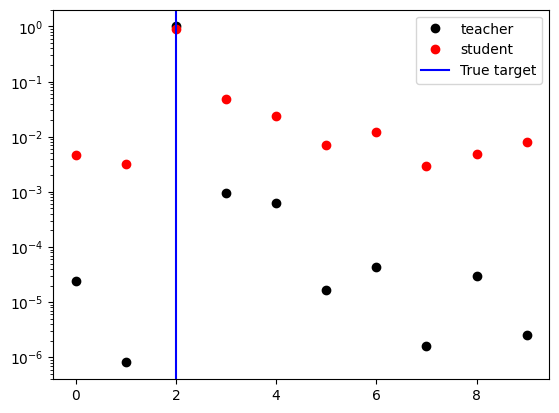

In [13]:
idx = 107
plot_teacher_student_outputs(teacher_retain_tensor[idx], student_logits[idx], y_retain_tensor[idx])

## Knowledge distillation

In [14]:
def calculate_kl_loss(student_logits, teacher_logits, T=2.0, forget_flag=False):
    
    teacher_logits = teacher_logits/T

    if forget_flag:
        forget_T = 5.0
        teacher_logits = teacher_logits/forget_T
        teacher_logits = teacher_logits + 0.05*torch.rand(teacher_logits.shape)

    # Calculate soft labels from teacher
    teacher_probs = F.softmax(teacher_logits, dim=1)

    # Compute distillation loss
    student_log_probs = F.log_softmax(student_logits.to('cpu')/T, dim=1)
    distillation_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (T * T)

    return distillation_loss

In [15]:
# Function to update learning rate
def adjust_learning_rate(optimizer, current_batch, total_batches, initial_lr):
    """Sets the learning rate for warmup over total_batches"""
    lr = initial_lr * (current_batch / total_batches)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [42]:
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)

# Apply pruning
pct = 0.95
global_unstructure_prune(model, pct)

# Freeze the first N-X layers
# num_layers_to_finetune = 9
# ct = 0
# for name, param in model.named_parameters():
#     ct += 1
#     if ct < num_layers_to_finetune:
#         param.requires_grad = False
#     else:
#         param.requires_grad = True

In [43]:
model.train()

epochs = 1

# LR warmup - Retain
total_samples = len(retain_loader.dataset)
batch_size = retain_loader.batch_size
batches_per_epoch  = math.ceil(total_samples / batch_size)
initial_lr = 0.001
warmup_batches = math.ceil(0.8*batches_per_epoch)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


current_batch = 0

for ep in range(epochs):

        iter_retain = iter(retain_loader)
        iter_retain_logit = iter(retain_logit_loader)
        iter_forget = iter(forget_loader)
        iter_forget_logit = iter(forget_logit_loader)

        # Initialize flag for depleted iterator
        one_depleted = False

        for _ in range(batches_per_epoch):
        # while not one_depleted:

            weights = torch.tensor([90, 10], dtype=torch.float32)

            # Randomly choose a loader based on weights
            chosen_loader_idx = torch.multinomial(weights, 1).item()
            
            if current_batch < math.ceil(0.1*batches_per_epoch):
                input_batch = next(iter_retain)
                logits_batch = next(iter_retain_logit)
                forget_flag = 0
                current_batch += 1
                multiplier = 1
            else:
                if chosen_loader_idx == 0:  # corresponds to retain_loader
                    try:
                        input_batch = next(iter_retain)
                        logits_batch = next(iter_retain_logit)
                        forget_flag = 0
                        current_batch += 1
                        multiplier = 1
                    except StopIteration:
                        one_depleted = True
                        continue  # Skip to the next iteration
                        
                else:  # corresponds to forget_loader
                    try:
                        input_batch = next(iter_forget)
                        logits_batch = next(iter_forget_logit)
                        forget_flag = 1
                        current_batch += 1
                        multiplier = -1
                    except StopIteration:
                        one_depleted = True
                        continue  # Skip to the next iteration

            inputs, targets = input_batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            logits_batch = logits_batch

            if current_batch <= warmup_batches:
                adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()
            student_logits = model(inputs)
            classification_loss = criterion(student_logits, targets)
            divergence_loss = calculate_kl_loss(student_logits, logits_batch, T=5, forget_flag=forget_flag)
            alpha = 0.1
            loss = (alpha*divergence_loss + (1-alpha)*classification_loss)*multiplier
            loss.backward()
            optimizer.step()
        scheduler.step()

model.eval();

In [44]:
student_retain_logits = torch.zeros(len(retain_loader.dataset), 10)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in retain_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = model(inputs.to(DEVICE))
        student_retain_logits[start_idx:end_idx] = outputs.cpu()
        start_idx = end_idx

student_forget_logits = torch.zeros(len(forget_loader.dataset), 10)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in forget_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = model(inputs.to(DEVICE))
        student_forget_logits[start_idx:end_idx] = outputs.cpu()
        start_idx = end_idx

c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


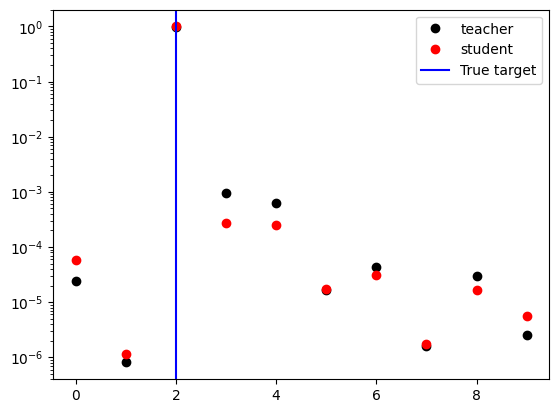

In [45]:
idx = 107
plot_teacher_student_outputs(teacher_retain_tensor[idx]/1, student_retain_logits[idx], y_retain_tensor[idx])

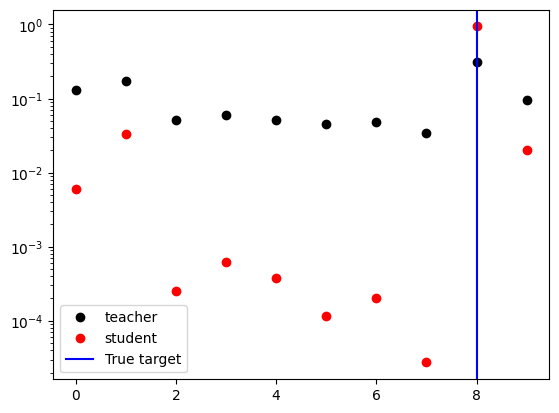

In [46]:
idx = 20
plot_teacher_student_outputs(teacher_forget_tensor[idx]/5+0.05*torch.rand(teacher_forget_tensor[idx].shape), student_forget_logits[idx], y_forget_tensor[idx])

## Evaluation

In [47]:
print(f"Retain set accuracy: {100.0 * accuracy(model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(model, forget_loader):0.1f}%")
print(f"Val set accuracy: {100.0 * accuracy(model, val_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Retain set accuracy: 99.5%
Forget set accuracy: 98.5%
Val set accuracy: 88.4%
Test set accuracy: 88.2%


## MIA

In [48]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [49]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [50]:
ft_retain_losses = compute_losses(model, retain_loader)
ft_forget_losses = compute_losses(model, forget_loader)
ft_test_losses = compute_losses(model, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [51]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.567 on forgotten vs unseen images


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001AA3602E560>
Traceback (most recent call last):
  File "c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


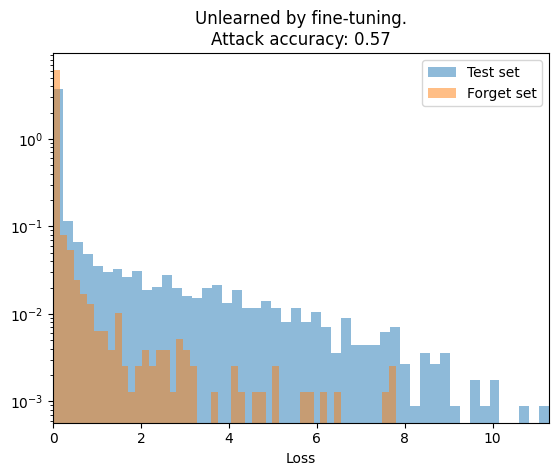

In [52]:
fig = plt.Figure(figsize=(16, 6))

plt.title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
plt.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

plt.xlabel("Loss")
plt.yscale("log")
plt.xlim((0, np.max(ft_test_losses)))
plt.legend()

plt.show()

## MIA #2

In [53]:
def entropy(p, dim = -1, keepdim = False):
    return -torch.where(p > 0, p * p.log(), p.new([0.0])).sum(dim=dim, keepdim=keepdim)

def collect_prob(data_loader, model):   
    data_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, shuffle=False, num_workers = 32, prefetch_factor = 10)
    prob = []
    with torch.no_grad():
        for batch in data_loader:
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            data, target = batch
            output = model(data)
            prob.append(F.softmax(output, dim=-1).data)
    return torch.cat(prob)

def get_membership_attack_data(retain_loader, forget_loader, test_loader, model):    
    retain_prob = collect_prob(retain_loader, model)
    forget_prob = collect_prob(forget_loader, model)
    test_prob = collect_prob(test_loader, model)
    
    X_r = torch.cat([entropy(retain_prob), entropy(test_prob)]).cpu().numpy().reshape(-1, 1)
    Y_r = np.concatenate([np.ones(len(retain_prob)), np.zeros(len(test_prob))])
    
    X_f = entropy(forget_prob).cpu().numpy().reshape(-1, 1)
    Y_f = np.concatenate([np.ones(len(forget_prob))])
    return X_f, Y_f, X_r, Y_r

def get_membership_attack_prob(retain_loader, forget_loader, test_loader, model):
    X_f, Y_f, X_r, Y_r = get_membership_attack_data(retain_loader, forget_loader, test_loader, model)
    clf = SVC(C=3,gamma='auto',kernel='rbf')
    #clf = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='multinomial')
    clf.fit(X_r, Y_r)
    results = clf.predict(X_f)
    return results.mean()

In [54]:
get_membership_attack_prob(retain_loader, forget_loader, test_loader, model)

c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


KeyboardInterrupt: 